## Chapter 16_Reinforcement Learning

This notebook contains all the sample code and solutions to the exersices in chapter 16.

强化学习（RL）是当今机器学习中最激动人心的领域之一，也是最古老的领域之一。它自20世纪50年代以来一直存在，多年来产生了许多有趣的应用，特别是在游戏中（例如，TD-Gammon，步步高游戏程序）和机器控制，但很少成为头条新闻。但是一场革命发生在2013年，当时一家名为DeepMind的英国创业公司的研究人员展示了一种可以学习从头开始玩任何Atari游戏的系统，在大多数情况下最终超过人类，仅使用原始像素作为输入而没有任何事先了解比赛规则。 

这是一系列令人惊叹的壮举中的第一个，最终于2016年3月以他们的AlphaGo系统对阵Go游戏世界冠军Lee Sedol的胜利而告终。没有任何节目能够击败这个游戏大师，更不用说世界冠军了。今天，RL的整个领域沸腾了新的想法，具有广泛的应用。 2014年，谷歌以超过5亿美元的价格收购了DeepMind。


那他们是怎么做到的？事后看来似乎很简单： 他们将深度学习的力量应用到强化学习领域，并且超越了他们最疯狂的梦想。在本章中，我们将首先解释强化学习是什么以及它擅长什么，然后我们将介绍深度强化学习中最重要的两种技术：**策略梯度和深度Q-网络（DQN）**，包括对马尔可夫决策过程（MDP）的讨论。我们将使用这些技术来训练模型以平衡移动车上的杆和另一个玩Atari游戏。 相同的技术可用于各种任务，从步行机器人到自动驾驶汽车。

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "16_Reinforcement Learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

注意：此笔记本的输出与本书中显示的示例之间可能存在细微差别。 您可以放心地忽略这些差异。 它们主要是由于OpenAIgym 提供的大多数环境具有一定的随机性。

## 1. Learning to Optimize Rewards

在强化学习中，agent在**环境**中进行**观察**并采取**行动**，作为回报，它会收到**奖励**。其**目标**是学会以最大化其预期的长期奖励的方式行事。

如果你不介意一些拟人化，你可以把积极的奖励视为快乐，将负面的奖励视为痛苦（在这种情况下，“奖励”一词有点误导）。 简而言之，agent在环境中行动并通过反复试验来学习，以最大限度地提高其乐趣并最大限度地减少其痛苦。

请注意，可能根本没有任何积极的奖励;例如，agent可能会在迷宫中四处走动，在每个时间步都获得**负面奖励**，因此最好尽快找到出口！ 还有许多其他任务的例子，其中强化学习非常适合，例如**自动驾驶汽车**，在**网页上放置广告**，或**控制图像分类系统应该集中注意力的位置**。

## 2. Policy Search

agent用于确定其操作的算法称为**策略**。例如，该策略可以是一个神经网络，**将观察作为输入，输出要采取的动作**（见图16-2）。
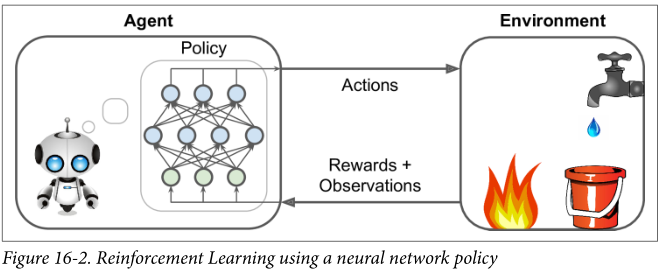

该策略可以是你能想到的任何算法，它甚至不必是确定性的。例如，考虑一个机器人吸尘器，其奖励是它在30分钟内吸收的灰尘量。它的策略可能是以每秒概率p向前推进，或者以$1-p$的概率向左或向右随机旋转。旋转角度是$-r$和$+ r$之间的随机角度。由于该策略涉及一些随机性，因此称为**随机策略**。机器人将具有不稳定的轨迹，这保证它最终将到达它可以到达的任何地方并拾取所有灰尘。 问题是：它会在30分钟内吸收多少灰尘？

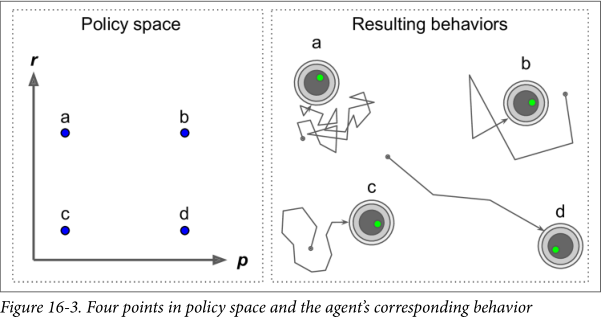

你会如何训练这样的机器人？你可以调整两个**策略参数：概率 p 和角度范围 r **。

一种可能的学习算法可能是为这些参数尝试许多不同的值，并选择性能最佳的组合（见图16-3）。这是**策略搜索**的一个例子，在这种情况下使用**蛮力方法**。但是，当**策略空间**太大时（通常就是这种情况），以这种方式找到一组好的参数就像在巨大的干草堆中寻找一根针。

探索策略空间的另一种方法是使用**遗传算法**。例如，你可以随机创建第一代100个策略并尝试它们，然后“杀死”80个最差的策略并使20个幸存者每个产生4个后代。后代只是其父母的副本加上一些随机变异。幸存的策略加上他们的后代共同组成了第二代。你可以通过这种方式继续迭代，直到找到一个好的策略。

另一种方法是使用**优化技术**，通过评估关于策略参数的奖励的梯度，然后通过遵循向更高奖励的梯度（**梯度上升**）来调整这些参数。这种方法称为**策略梯度（PG）**，我们将在本章后面详细讨论。

例如，回到真空吸尘器机器人，你可以略微增加 p 并评估是否会增加机器人在30分钟内拾取的灰尘量; 如果确实如此，那么再增加 p，否则减少 p。

我们将使用TensorFlow实现流行的PG算法，但在我们开始之前，我们需要为 agent 创建一**个环境**，因此是时候介绍OpenAI gym了。

## 3. Introduction to OpenAI gym

强化学习的挑战之一是为了训练agent，你首先需要有一个工作环境。如果你想编写一个学习玩Atari游戏的代理，你将需要一个Atari游戏模拟器。如果你想对步行机器人进行编程，那么环境就是现实世界，你可以直接在该环境中训练您的机器人，但这有其局限性：如果机器人从悬崖上掉下来，你不能单击“撤消”。 “你也无法加快时间;增加更多的计算能力不会让机器人移动得更快。并行训练1,000个机器人通常太昂贵了。简而言之，在现实世界中，训练是艰难而缓慢的，因此你通常至少需要一个模拟环境进行训练。

OpenAI gym 是一个工具包，提供各种模拟环境（Atari游戏，棋盘游戏，2D和3D物理模拟等），所以你可以训练 agent，比较它们或开发新的RL算法

可以通过pip 等途径安装OpenAI gym，具体的安装步骤已经超出了此笔记本的范围，因此这里不对安装做过多讲解

### 3.1  A simple environment: the Cart-Pole

Cart-Pole是一个非常简单的环境，由可以向左或向右移动的推车组成，并且杆垂直放置在其上方。
agent必须向左或向右移动推车以使杆保持直立。

创建你的第一个环境：

In [2]:
import gym
gym.logger.set_level(40)# 忽略不必要的广告

In [3]:
env = gym.make("CartPole-v0")

In [4]:
obs = env.reset()

In [5]:
obs

array([ 0.04740558,  0.01763346, -0.04540156, -0.00821724])

**make（）函数**创建一个环境，在本例中为CartPole环境。这是2D模拟其中可以向左或向右加速推车以平衡放置在其顶部的杆（参见图16-4）。创建环境后，我们必须使用**reset（）方法**对其进行初始化。这将返回第一个**observation**
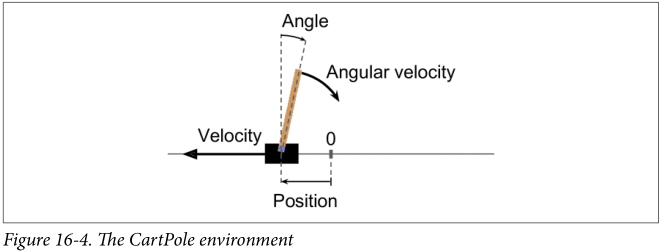

 **observation** 是由4个浮点组成的1D NumPy阵列：它们代表推车的**水平位置**，**速度**，**极点的角度**（0 =垂直）和**角速度**。 让我们渲染一下环境......不幸的是，我们需要先解决烦人的渲染问题。

### 3.2  Fixing the rendering issue

某些环境（包括Cart-Pole）需要访问你的显示器，即使你指定了rgb_array模式，也会打开一个单独的窗口。 通常，你可以安全地忽略该窗口。

但是，如果Jupyter在无头服务器上运行（即没有屏幕），它将引发异常。 避免这种情况的一种方法是安装虚拟X服务器，如Xvfb。你可以使用xvfb-run命令启动Jupyter：

``` $ xvfb-run -s“-screen 0 1400x900x24”jupyter notebook ```

如果Jupyter在无头服务器上运行但你不想担心Xvfb，那么你可以使用以下渲染函数来实现Cart-Pole：
   

In [6]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


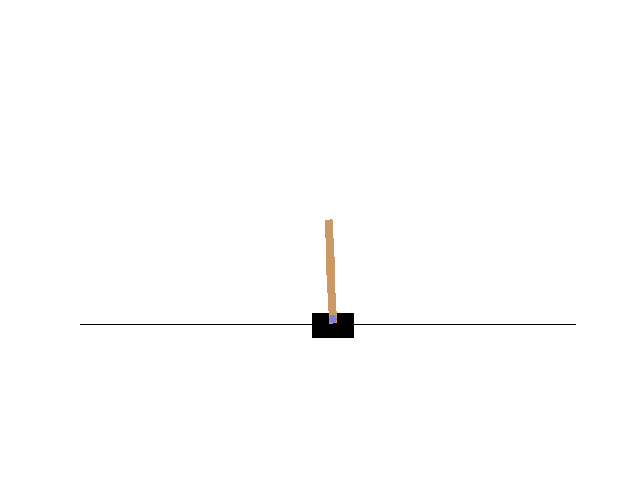

In [7]:
plot_cart_pole(env, obs)

现在让我们看看动作空间：

In [8]:
env.action_space

Discrete(2)

In [9]:
action=1 # accelerate right

In [10]:
obs, reward, done, info = env.step(action)

In [11]:
obs

array([ 0.04775825,  0.21337613, -0.04556591, -0.31487216])

In [12]:
reward

1.0

In [13]:
done

False

In [14]:
info

{}

step（）方法执行给定的操作并返回四个值：

obs
这是新observation。推车现在向左移动（obs [1]< 0）。杆仍然向右倾斜（obs [2]> 0），但现在它的角速度正（obs [3] 》0），因此在下一步之后它可能会向右倾斜。

reward
在这种环境中，无论你做什么，每一步都会获得1.0的奖励，所以目标是尽可能长时间地运行。

done
当剧集结束时，该值将为True。当杆子倾斜太多时会发生这种情况。之后，必须重置环境才能再次使用。

info
该字典可以在其他环境中提供额外的调试信息。这些数据不应用于训练（这将是作弊）。


是的，只有两个可能的动作：向左或向右加速。Discrete(2)意味着可能的动作是整数0和1，它们代表加速左（0）或右（1）。
其他环境可以具有更多离散动作或其他类型的动作（例如，连续的）。 

让我们向左推车直到杆倒下：

In [15]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


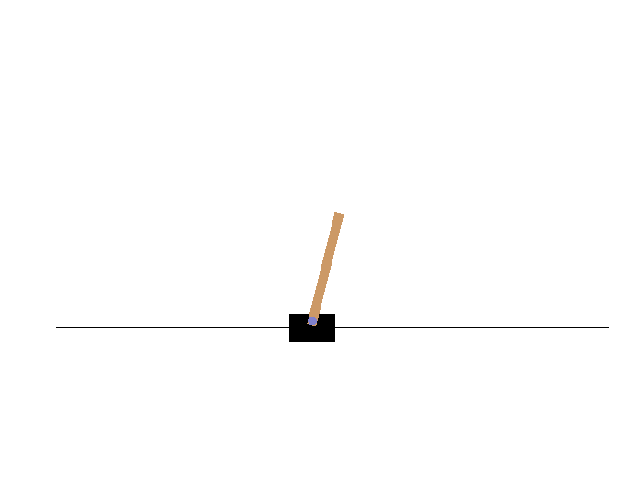

Saving figure cart_pole_plot


In [16]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
save_fig("cart_pole_plot")

In [17]:
img.shape

(400, 600, 3)

请注意，当杆子倾斜太多时游戏结束，而不是当它实际下降时。 现在让我们重置环境并将购物车推向右边：

In [18]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


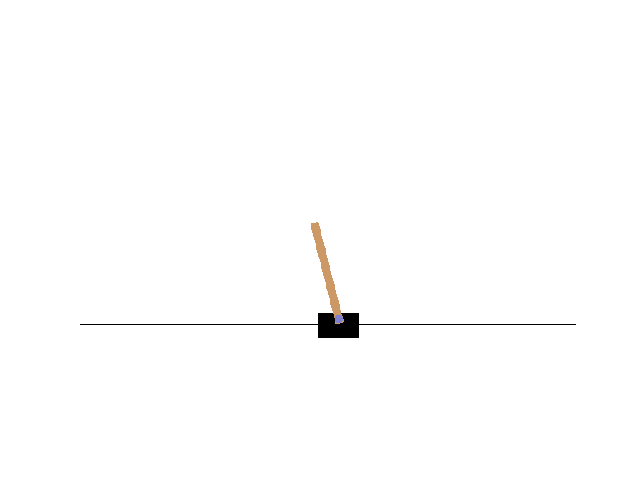

In [19]:
plot_cart_pole(env, obs)

看起来它正在做我们告诉它要做的事情。现在我们怎样才能使杆调查保持正常？ 我们需要为此定义一个_policy_。 这是agent将用于在每个步骤选择操作的策略。它可以使用所有过去的操作和观察来决定做什么。

### 3.3  A simple hard-coded policy


让我们硬编码一个简单的策略：如果杆向左倾斜，则将推车推向左侧，然后将装置推向左侧。 让我们看看是否有效：

In [20]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

In [21]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(
        fig, 
        update_scene, 
        fargs=(frames, patch), 
        frames=len(frames), 
        repeat=repeat, 
        interval=interval
    )

<IPython.core.display.Javascript object>


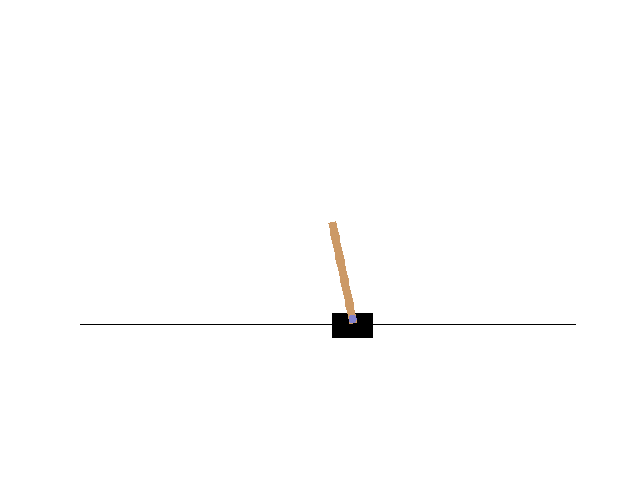

In [22]:
video = plot_animation(frames)
plt.show()

系统是不稳定的，经过几次摆动后，杆子最终倾斜了：游戏结束。 我们需要比这更聪明！

## 4.  Neural Network Policies

让我们创建一个**神经网络策略**。就像我们之前硬编码的策略一样，这个神经网络**将观察作为输入**，**将输出要执行的动作**。更准确地说，它将**估计每个动作的概率**，然后我们将根据估计的概率随机选择一个动作（见图16-5）。对于CartPole环境，只有两个可能的动作（左或右），所以我们只需要一个输出神经元。它将输出动作0的概率p（左），当然动作1（右）的概率为1 - p。例如，如果它输出0.7，那么我们将以70％的概率选择动作0，并且行动1，概率为30％。

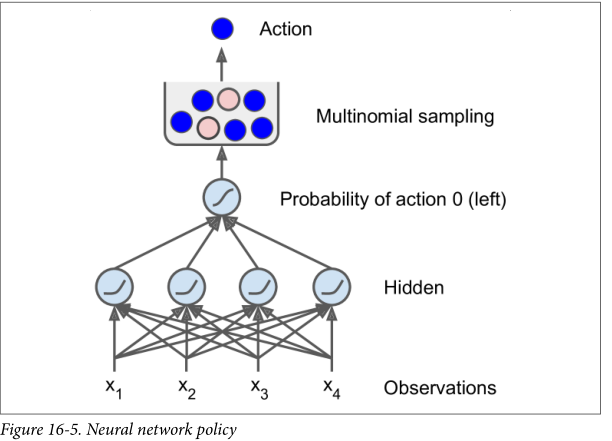

你可能想知道为什么我们基于神经网络给出的概率选择随机动作，而不是仅选择具有最高分数的动作。

这种方法可以**让agent在探索新操作和利用已知运行良好的操作之间找到适当的平衡点**。

这是一个类比：假设你第一次去餐厅，所有的菜肴看起来都很吸引人，所以你随机选择一个。如果事实证明是好的，你可以增加下次订购它的可能性，但你不应该把这个概率增加到100％，否则你永远不会尝试其他菜肴，其中一些甚至可能更好比你试过的那个。

还要注意，在这个特定的环境中，过去的行动和观察可以安全地被忽略，因为每个观察包含环境的完整状态。如果存在某种隐藏状态，那么你可能还需要考虑过去的行动和观察。

* 例如，如果环境只显示推车的位置但不显示其速度，则不仅要考虑当前的观察，还要考虑先前的观察，以便估计当前的速度。

* 另一个例子是观察结果很嘈杂; 在这种情况下，你通常希望使用过去几次观察来估计最可能的当前状态。CartPole问题因此是可以的; 观察结果是无噪声的，它们包含环境的完整状态。

以下是使用TensorFlow构建此神经网络策略的代码：

注意：我们现在使用**tf.layers模块中的dense（）函数**，而不是使用tensorflow.contrib.layers模块中的fully_connected（）函数，该函数在编写本章时不存在。 这是首选，因为contrib中的任何内容都可能更改或删除，恕不另行通知，而tf.layers是官方API的一部分。 不过代码大致相同。

与本章相关的主要差异是：

* 删除了所有参数中的_fn后缀（例如，activation_fn参数已重命名为激活）。
* 权重参数重命名为kernel，
* 默认activation为None而不是tf.nn.relu

In [23]:
import tensorflow as tf

# 1. 指定网络体系结构
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # 这是一项简单的任务，我们不需要太多层数
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.variance_scaling_initializer()

# 2. 建立神经网络
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)

# 3.根据估计的概率选择随机动作
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

我们来看看这段代码：

1. 导入后，我们定义神经网络架构。**输入的数量是观察空间的大小**（在CartPole为4的情况下），我们只有**四个隐藏神经元**（即一层）而不需要更多，我们只有**一个输出概率**（向左移动的概率）。

2. 接下来我们建立神经网络。在这个例子中，它是一个带有单个输出的vanilla 多层感知器。请注意，输出层使用逻辑（sigmoid）激活函数，以便输出**0.0到1.0的概率**。如果有两个以上可能的动作，每个动作将有一个输出神经元，你将使用softmax激活函数。
3. 最后，我们调用**multinomial（）函数**来选择随机动作。在给定每个整数的对数概率的情况下，该函数独立地对一个（或多个）整数进行采样。例如，如果用数组[np.log（0.5），np.log（0.2），np.log（0.3）]和num_samples = 5调用它，那么它将输出五个整数，每个都有50％的概率为 0 ,20％为 1 ，30％为 2 。在我们的例子中，我们只需要一个表示要采取的动作的整数。由于**输出张量**仅包含向左移动的概率，我们必须先把**（1-outputs）**和它进行连接，以使它成为**具有包含左右动作概率**的张量。

**请注意，如果有两个以上可能的操作，则神经网络必须为每个操作输出一个概率，因此你不需要连接步骤**。

好的，我们现在有一个神经网络策略，将采取观察和输出行动。但我们如何训练呢？

让我们随机初始化这个策略神经网络并用它来玩一个游戏：

In [24]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

现在让我们来看看这个随机初始化的策略网络的执行情况：

<IPython.core.display.Javascript object>


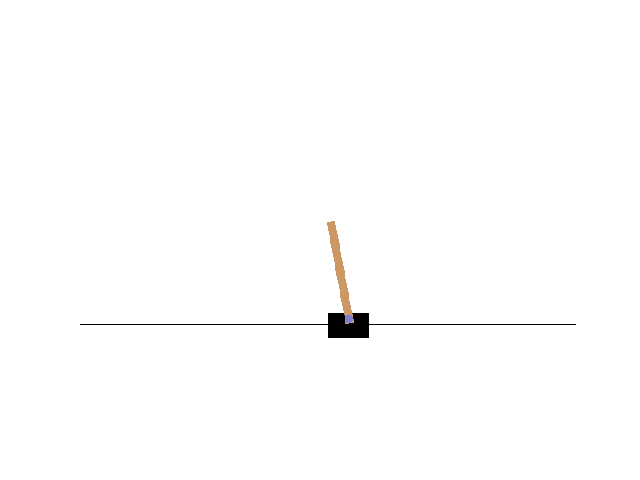

In [25]:
video = plot_animation(frames)
plt.show()

是的......非常糟糕神经网络必须学会做得更好。 首先让我们看看它是否能够学习我们之前使用的基本策略：**如果杆向左倾斜则向左移动，如果向右倾斜则向右移动**。

以下代码定义了相同的神经网络，但我们添加了**目标概率y和训练操作（cross_entropy，optimizer和training_op）**：

In [26]:
import tensorflow as tf

reset_graph()

# 1. 指定网络体系结构
n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

# 2. 建立神经网络
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)

# 3.根据估计的概率选择随机动作
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# 4.添加训练操作 （cross_entropy，optimizer和training_op）
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

我们可以**在10个不同的环境中并行进行相同的网络游戏**，并训练1000次迭代。 我们还在完成后重置环境。

In [27]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # if angle<0 we want proba(left)=1., or else proba(left)=0.
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) 
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [28]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


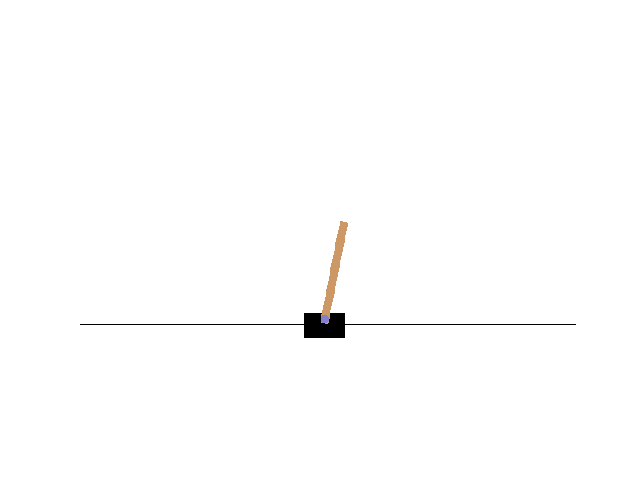

In [29]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

看起来它正确地学习了这个政策。 现在让我们看看它是否可以自己学习更好的政策。

## 5. Evaluating Actions: The Credit Assignment Problem

如果我们知道每个步骤的最佳动作是什么，我们可以像往常一样训练神经网络，通过最小化估计概率和目标概率之间的交叉熵。这是常规的监督学习。然而，在强化学习中，**agent获得的唯一指导是通过奖励，奖励通常是稀疏和延迟的**。

例如，如果agent设法平衡100个步骤的极点，那么它怎么知道它所采取的100个动作中的哪个是好的，哪个是坏的？所有这一切都知道，在最后一次行动之后杆子倒下了，但是最后一次行动肯定不是负全责的。这称为**信用分配问题**：

* 当agent获得奖励时，它很难知道哪些行动应该被归功于它（或归咎于它）。想想一只狗在表现良好后数小时获得奖励;它会理解它的回报吗？为了解决这个问题，**一个共同的策略是根据其后所有奖励的总和来评估一项行动，通常在每一步采用折扣率r**。


例如（见图16-6），如果一个agent决定**连续三次向右走**，并在第一步之后获得+10奖励，在第二步之后获得0，最后在第三步之后获得-50，然后假设我们使用**折扣率 r = 0.8**，第一个动作的总得分为$ 10 + r×0 + r^2×（ - 50）= -22 $。

* 如果**折扣率接近0**，那么与即时奖励相比，未来的奖励将不会太多。

* 相反，如果**折扣率接近1**，那么远期的奖励几乎与即时奖励一样多。典型折扣率为0.95或0.99。

折扣率为0.95，未来13步的奖励大约是即时奖励的一半（自0.9513≈0.5），而贴现率为0.99，未来69步的奖励是即时奖励的一半。

在CartPole环境中，操作具有相当短期的影响，因此选择0.95的折扣率似乎是合理的。

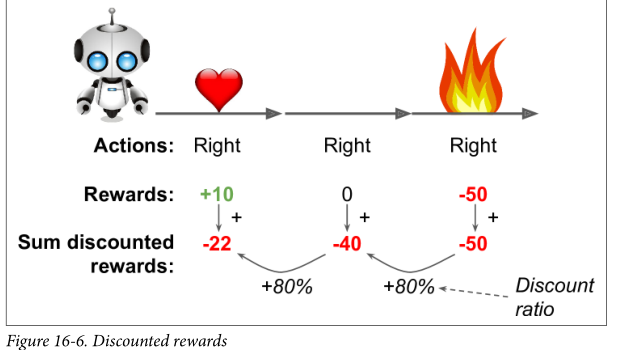

当然，一个好的动作之后可能会出现几个导致杆子快速下降的不良行为，导致好的动作获得低分（同样，一个好演员有时可能会出演一部糟糕的电影）。但是，如果我们玩足够多次游戏，平均而言，好的行为会比不好的行动得分更好。因此，为了获得相当可靠的动作分数，
* 我们必须运行多个 episodes **并将所有动作分数标准化（通过减去均值并除以标准差）**。

* 在那之后，我们可以合理地假设具有负分数的动作是差的，而具有正分数的动作是好的。 

现在我们有办法评估每个行动，我们准备使用**策略梯度**训练我们的第一个agent。 我们来看看如何。

## 6.  Policy Gradients

如前所述，PG算法通过跟随梯度向更高的奖励来优化策略的参数。一种流行的PG算法，称为**REINFORCE算法**，于1992年由Ronald Williams引入。这是一个常见的变体：

1. 首先，让神经网络策略多次玩游戏，**at each step compute the gradients that would make the chosen action even more likely**,，但是不要应用这些梯度。

2. 运行多个episodes后，计算每个动作的分数（使用前一段中描述的方法）。


3. 如果某个动作的分数为正，这意味着该动作很好，并且你希望应用之前计算的梯度，以使该动作更有可能在将来被选中。但是，如果得分为负，则表示操作很糟糕，并且你希望应用相反的梯度来使此操作在将来稍微不太可能被选中。解决方案是简单地**将每个梯度向量乘以相应的动作得分**。

4. 最后，计算所有得到的梯度向量的平均值，并用它来执行Gradient Descent步骤。

让我们使用TensorFlow实现这个算法。我们将训练我们之前建立的神经网络策略，以便它学会平衡推车上的杆。让我们首先完成我们之前编码的**构建阶段**，以添加**目标概率，成本函数和训练操作**。

由于我们的行为就好像所选择的动作是最好的动作一样，
* 如果所选动作是动作0（左），目标概率必须是1.0，
* 如果是动作1（右），则目标概率必须是0.0：

为了训练这个神经网络，我们需要定义**目标概率y**。

* 如果一个动作是好的，我们应该增加它的概率，
* 如果它是坏的，我们应该减少它。 但我们如何知道行动是好还是坏？

问题是大多数动作都有延迟效果，所以当你在游戏中赢或输分数时，不清楚哪种动作对这个结果有贡献：它只是最后一个动作吗？ 还是最后10个动作？ 或者只提前50步的一个动作？这称为**信用分配问题**。

Policy Gradients算法通过首先玩多个游戏，然后在好游戏中进行操作稍微更有可能，而在坏游戏中的操作稍微不太可能，解决了这个问题
我们先玩游戏，然后我们回去思考我们做了什么。

**the full construction phase**

In [30]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# 目标概率y
y = 1. - tf.to_float(action)

# 定义损失函数，计算梯度
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# 请注意，我们正在调用优化器的compute_gradients（）方法而不是minimize（）方法。
# 这是因为我们想在应用梯度之前调整梯度。
# compute_gradients（）方法返回梯度向量/变量对的列表（每个可训练变量一对）。
# 让我们将所有梯度放在一个列表中，以便更方便地获取它们的值：

gradients = [grad for grad, variable in grads_and_vars]

# 好的，现在是棘手的部分。在执行阶段，算法将运行策略，并在每个步骤评估这些梯度张量并存储它们的值。
# 在一些epoches 之后，它将调整这些梯度，如前所述（即，将它们乘以动作分数并将它们标准化）并计算调整梯度的平均值。
# 接下来，它需要将生成的梯度反馈给优化器，以便它可以执行优化步骤。
# 这意味着每个梯度向量需要一个占位符。
# 此外，我们必须创建一个使用更新过的梯度的操作
# 为此，我们将调用优化器的apply_gradients（）函数，该函数获取梯度向量/变量对的列表。
# 我们将给它一个包含更新梯度的列表（即通过梯度占位符提供的梯度），而不是给它原始的梯度向量：

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

**the execution phase**

我们需要一些函数在给定原始奖励的基础上，来计算**总折扣奖励**，并在多个epoch中规范化结果：

In [31]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

让我们检查一下这是否有效：

In [32]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [33]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

对**discount_rewards（）**的调用完全符合我们的预期（见图16-6）。你可以验证一下函数**discount_and_normalize_rewards（）**确实返回两集中每个动作的规范化分数。

请注意，the first episode 比the second差得多，因此其标准化分数均为负数; 
* the first episode 中的所有动作都将被视为不良，
* 相反，the second 中的所有动作都将被认为是好的。

我们现在拥有训练策略所需的一切：

In [34]:
env = gym.make("CartPole-v0")

n_games_per_update = 10 # train the policy every 10 episodes
n_max_steps = 1000      # max steps per episode
n_iterations = 250      # number of training iterations
save_iterations = 10    # save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []    # all sequences of raw rewards for each episode
        all_gradients = []  # gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = []   # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

每次训练迭代都是通过运行10个 epoches 的策略开始的（每集最多1000步，以避免永远跑步）。

* 在每一步，我们还计算梯度，假装所选择的动作是最好的。在这10个 epoches之后，我们使用**discount_and_normal ize_rewards（）函数**计算动作得分;

* 我们遍历所有epoches和所有步骤中的每个可训练变量，将每个梯度向量乘以其相应的动作得分;我们**计算得到的梯度的平均值**。
* 最后，我们运行训练操作，为它们提供这些平均梯度（每个可训练变量一个）。我们还**每10次训练操作保存模型**。



此代码将训练神经网络策略，它将成功学习平衡推车上的杆（您可以在Jupyter笔记本中试用它）。请注意，agent 实际上有两种方式可以输掉游戏：**杆子可能会倾斜太多，或者推车可能完全脱离屏幕**。

通过250次训练迭代，该策略学会了很好地平衡杆位，但它还不足以避免离开屏幕。几百次训练迭代将解决这个问题

In [35]:
env.close()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


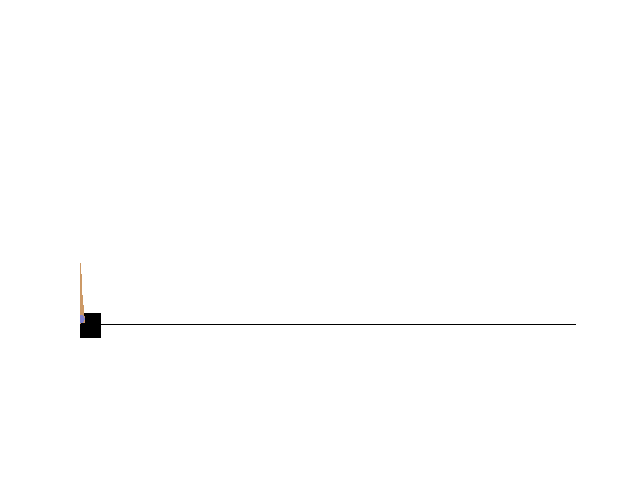

In [36]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

研究人员试图找到即使 agent 最初对环境一无所知也能很好地工作的算法。 但是，除非你正在撰写论文，否则你应该尽可能多地将**先验知识**注入 agent ，因为它会大大加快训练速度。例如，

* 你可以添加**与屏幕中心距离和极点角度成比例的负奖励**。

* 此外，如果你已经有一个相当好的策略（例如，硬编码），你可能需要训练神经网络来模仿它，然后再使用策略渐变来改进它。



尽管相对简单，但该算法非常强大。 你可以用它来解决比平衡车上的杆更困难的问题。事实上，AlphaGo基于类似的PG算法（加上蒙特卡罗树搜索，这超出了本书的范围）。

我们现在将看另一个流行的算法系列。虽然PG算法直接尝试优化策略以增加奖励，但我们现在将看到的算法不那么直接：
代理人学会估计
* **每个state**的预期未来奖励的预期总和，或者
* **每个state每个行动**的预期未来奖励的预期总和，然后使用这些知识来决定如何行动。

要理解这些算法，我们必须首先介绍马尔可夫决策过程（MDP）。

## 7.0 Markov Chains

在20世纪初期，数学家安德烈马尔科夫研究了没有记忆的随机过程，称为**马尔可夫链**。这样的过程具有固定数量的状态，并且在每个步骤中从一个状态随机地演变为另一个状态。它从状态 $s$ 演变到状态 $s'$ 的概率是固定的，它只取决于状态对儿$(s，s')$，而不取决于过去的状态（系统没有记忆）。

图16-7显示了具有四种状态的马尔可夫链的示例。

* 假设进程在状态$s_0$开始，并且有70％的可能性它将在下一步保持该状态。

* 最终它必然会离开那个状态并且永远不会回来，因为没有其他状态指向回到0。

* 如果它进入状态$s_1$，那么它很可能会进入状态$s_2$（概率为90％），然后立即回到状态$s_1$（概率为100％）。

* 它可能在这两个状态之间交替多次，但最终它将落入状态$s_3$并永远保持在那里（这是一个**终端状态**）。

马尔可夫链可以具有非常不同的动力学，它们大量用于热力学，化学，统计学等等。

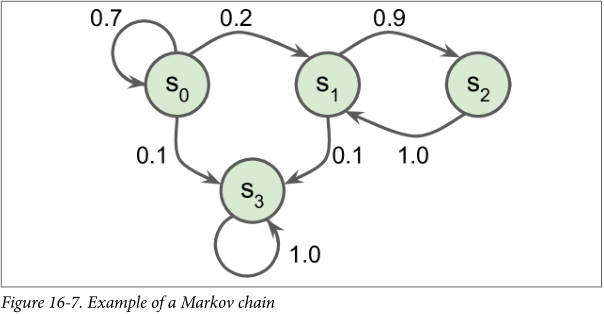

In [37]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0],  # from s3 to ...
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## 7.1  Markov Decision Process

20世纪50年代，理查德·贝尔曼首次描述了马尔可夫决策过程。它们类似于马尔可夫链，但有一个转折点：
**在每个步骤中，agent 可以选择几种可能的动作之一，并且转移概率取决于所选择的动作**。

此外，一些状态转换会返回一些奖励（正面或负面），而**agent的目标是找到一种能够随着时间的推移最大化回报的策略**。

图16-8中表示的MDP在每一步都有**三种状态**和**最多三种可能的离散动作**。

* 如果它在状态$ s_0$中开始，则代理可以在动作$a_0$，$a_1$或$a_2$之间进行选择。
   * 如果它选择动作 **1**，它只是确定地保持在状态0，并且没有任何奖励。因此，它可以决定永远留在那里，如果它想要的话。
   * 但如果它选择动作 **0**，它有70％的概率获得+10的奖励，并且留在状态0。然后它可以一次又一次地尝试获得尽可能多的奖励。

* 但有一次，它最终会以状态 $s_1$ 结束。在状态$s_1$ 中，它只有两个可能的动作：0或2。 它可以通过反复选择动作0选择保持不变，或者它可以选择继续进入状态$s_2$ 并获得-50（ouch）的负面奖励。


在状态$s_2$ 中，除了采取动作 **1** 之外没有其他选择，这很可能导致它回到状态$ s_0$，在途中获得+40的奖励。你得到了照片。

通过查看此MDP，你能猜出哪种策略会随着时间的推移获得最大回报吗？在状态$ s_0$中，显然动作$ a_0$是最佳选择，并且在状态$s_2$中，代理别无选择，只能采取动作**1**，

但是在状态$ s_1$中，代理人是应该保持原地（$a_0$）还是通过火场（$a_2$）并不明显。

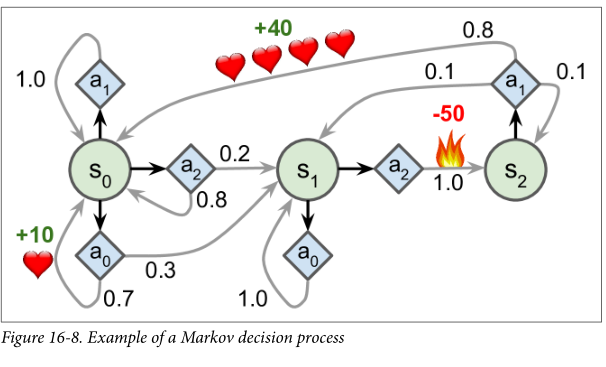

贝尔曼找到了一种估算任何状态s的最佳状态值的方法，记为$V^*(s)$，这是 agent 平均可以预期的所有折扣的未来奖励总和
在它达到状态s之后，假设它的行动是最优的。

他表明，如果 agent 最优的运行，那么可以应用Bellman最优方程（见公式16-1）。这个递归方程表明，**如果 agent 的行为最优，那么当前状态的最优值等于采取一个最优行动后平均得到的奖励，加上此操作可能导致的所有可能的下一个状态的预期最优值**。

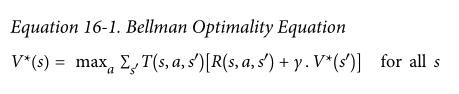

* $T（s，a，s'）$是从状态 $s$ 到状态 $s'$ 的转换概率，基于agent 选择了动作 $a$。
* $R（s，a，s'）$是 agent 从状态 $s$ 到状态$s'$时获得的奖励，基于agent选择了动作 $a$。
* $γ$是折扣率。

**该等式直接导致算法可以精确估计每个可能状态的最优状态值**：

* 首先将所有状态值估计值初始化为零，
* 然后使用**值迭代算法（Value Iteration algorithm）**迭代更新它们（参见公式16-2）。

一个显着的结果是，**如果有足够的时间，这些估计值将保证收敛到最优状态值，对应于最优策略**。

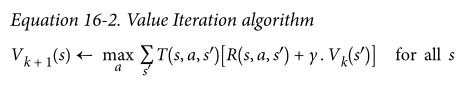

该算法是动态规划的一个例子，它将一个复杂的问题（在这种情况下，估计可能无限的折扣未来奖励总和）分解为易处理的子问题，可以迭代地解决（在这种情况下，找到最大化平均奖励的行动加上折扣的下一个状态值）。

了解最优状态值可能很有用，尤其是评估策略，但是它没有明确告诉 agent 该做什么。幸运的是，Bellman发现了一种非常相似的算法来估计**最优状态 - 动作值，通常称为Q值**。

**状态 - 动作对（s，a）的最佳Q值**，记为$ Q *(s,a)$，是 agent 在达到状态 $s$ 后平均可以预期的折扣未来奖励的总和并选择动作 $a$ ， 但是在它看到这个动作的结果之前，假设它在该动作之后发挥最优作用。

以下是它的工作原理：
* 首先将所有Q值估算值初始化为零，
* 然后使用Q值迭代算法更新它们（见公式16-3）。

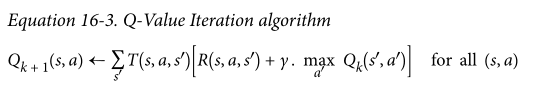

获得最优Q值后，定义最优策略，注意$π*(s)$，是微不足道的：当 agent 处于状态 s 时，它应该为该状态选择具有最高Q值的动作：
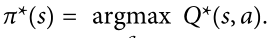

让我们将此算法应用于图16-8中所示的MDP。
 
**首先，我们需要定义MDP**：

In [38]:
nan = np.nan # repressents impossible actions
T = np.array([ # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
    [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
])

R = np.array([ # shape=[s, a, s']
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[10., 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
    [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
])

possible_actions = [[0, 1, 2], [0, 2], [1]]
    

现在让我们运行Q-Value Iteration算法：

In [39]:
Q = np.full((3, 3), -np.inf) # -inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0 # Initial value = 0.0, for all possible actions

learning_rate = 0.01
discount_rate = 0.95
n_iterations = 100

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                T[s, a, sp] * (R[s, a, sp] + discount_rate * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

生成的Q值如下所示：

In [40]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

In [41]:
np.argmax(Q, axis=1) # optimal action for each state

array([0, 2, 1], dtype=int64)

当使用 0.95 的折扣率时，这为我们提供了此MDP的最优策略：在状态$s_0$中选择动作$a_0$，在状态$s_1$中选择动作$a_2$（通过火场！），并在状态2中选择动作$a_1$（唯一可能的动作）。

有趣的是，如果你将折扣率降低到0.9，则最优策略会发生变化：在状态$s_1$中，最优动作变为0（保持不变;不要经历火场）。

这是有道理的，因为如果你比现在更重视现在，那么未来奖励的前景不值得立即痛苦。

In [42]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("States (+rewards):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 2 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = 210
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 2 (40) 0 (10) ... Total rewards = 70
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 70
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = -10
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) ... Total rewards = 290
Summary: mean=121.1, std=129.333766, min=-330, max=470

policy_random
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) 2 2 (40) 0 ... Total rewards = -60
States (+rewards): 0 (10) 0 0 0 0 0 (10) 0 0 0 (10) 0 ... Total rewards = -30
States (+rewards): 0 1 1 (-50) 2 (40) 0 0 1 1 1 1 ... Total rewards = 10
States (+rewards): 0 (10) 0 (10) 0 0 0 0 1 (-50) 2 (40) 0 0 ... Total rewards = 0
States (+rewards): 0 0 (10) 0 1 (-50) 2 (40) 0 0 0 0 (10) 0 (10) ... Total rewards = 40

## 8. Temporal Difference Learning and Q-Learning

离散动作的强化学习问题通常可以建模为马尔可夫决策过程，但是 agent 最初不知道转移概率是什么（它不知道$T(s，a，s')$），也不知道奖励会是什么（它不知道 $ R(s， a，s')$）。它必须至少经历每个状态和每个transition一次以了解奖励，并且如果要对转移概率进行合理估计，它必须多次经历它们。


**Temporal Difference Learning（TD Learning）算法**非常类似于值迭代算法，但调整后考虑到 agent 只对MDP有部分了解的事实。通常，
* 我们假设 agent 最初只知道可能的状态和动作，仅此而已。
* agent 使用探索策略（例如，纯粹随机的策略）来探索MDP，并且随着它的进展，TD学习算法基于实际观察到的transition和奖励来更新状态值的估计（参见等式16- 4）。

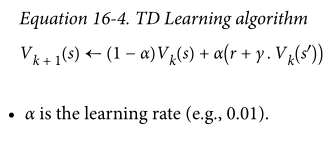

**TD Learning与Stochastic Gradient Descent有许多相似之处，特别是它一次处理一个样本。就像SGD一样，只有逐渐降低学习速度才能真正收敛（否则它会在最佳状态下保持弹跳）**。

对于每个**状态**，该算法简单地跟踪 agent 在离开该状态时所获得的直接奖励的运行平均值，以及它预期稍后获得的奖励（假设它acts optimally）。

类似地，Q-Learning算法是Q值迭代算法适应转移概率和奖励最初未知的情况（见公式16-5）。
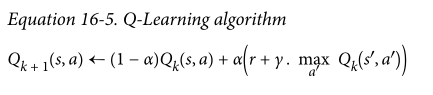

对于每个**状态 - 动作对（s，a）**，这个算法跟踪 agent 在离开状态 s 时采取动作 a 的奖励的运行平均值，以及预期稍后获得的奖励。由于目标策略将采取最优行动，因此我们对下一个状态采取最大Q值估计。
以下是Q-Learning的实施方式：

In [43]:
import numpy.random as rnd
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

s = 0 # start in state 0
Q = np.full((3, 3), -np.inf) # -inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0 # Initial value = 0.0, for all possible actions

for iteration in range(n_iterations):
    a = rnd.choice(possible_actions[s]) # 随机选择一个动作
    sp = rnd.choice(range(3), p=T[s, a]) # 使用T[s, a] 选择下一个状态
    reward = R[s, a, sp]
    learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
    Q[s, a] = learning_rate * Q[s, a] + (1 - learning_rate) * (
        reward + discount_rate * np.max(Q[sp])
    )
    s = sp # 移动到下一个状态

给定足够的迭代，该算法将收敛到最优Q值。这称为**off-policy** 算法，因为正在训练的策略不是正在执行的策略。

令人惊讶的是，该算法能够通过随机观察 agent 行为来学习最优策略（想象一下，当你的老师是醉猴时，学会打高尔夫球）。 我们可以做得更好吗？

### 8.1 Exploration Policies

当然只有在**探索策略**足够彻底地探索MDP时，Q-Learning才能发挥作用。虽然保证纯粹随机的策略最终会多次访问每个状态和每个transition，但这可能需要很长时间才能完成。因此，更好的选择是使用$ε$-**贪婪策略**：在每一步中，它以概率$ε$随机地行动，或者贪婪地（选择具有最高Q值的动作）概率为$1-ε$。

$ε$-贪婪策略（与完全随机的政策相比）的**优势在于它将花费越来越多的时间来探索环境的有趣部分，因为Q值估计变得越来越好，同时仍然花费一些时间来访问MDP的未知区域**。从$ε$（例如1.0）的高值开始然后逐渐减小它（例如，低至0.05）是很常见的。


或者，另一种方法是鼓励探索策略尝试以前没有尝试过的行动。而不是依赖于探索的机会。这可以作为添加到Q值估计的奖励来实现，如公式16-6所示。

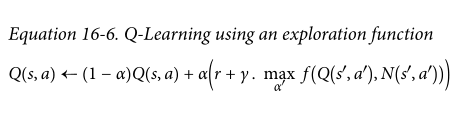

* $ N(s'，a') $计算在状态s'中选择动作a'的次数。

* $f(q，n)$是一个探索函数，如$f(q，n)= q + K /(1 + n)$，其中K是一个好奇心超参数，用于衡量 agent 被吸引到未知的程度。

### 8.2 Approximate Q-Learning

**Q-Learning的主要问题是它不能很好地扩展到具有许多状态和动作的大型（甚至是中型）MDP问题**。考虑尝试使用Q-Learning训练agent 扮演Pac-Man女士。Pac-Man女士可以吃250粒以上的药丸，每颗的状态可以是存在或不存在（即已经吃过）。所以可能状态的数量大于$2^{250}≈10^{75}$（并且考虑到药丸的可能状态）。这比可观察宇宙中的原子更多，因此绝对没有办法跟踪每个Q值的估计值。

找到一个使用参数数量可管理的函数来近似Q值。这称为**近似Q-Learning**。多年来，建议使用从状态中提取的手工制作的特征的线性组合（例如，最近的重影的距离，它们的方向等）来估计Q值，但是DeepMind表明使用深度神经网络可以工作更好，特别是对于复杂的问题，它不需要任何特征工程。用于估计Q值的DNN称为**深度Q网络**（DQN），使用DQN进行近似Q学习称为**深度Q学习**。

在本章的其余部分，我们将使用Deep Q-Learning训练agent扮演Ms.Pac-Man，就像DeepMind在2013年所做的那样。代码可以很容易地调整，以学习很好地播放大多数Atari游戏。它可以在大多数动作游戏中实现超过人类的技能，但是对于长期运行故事情节的游戏来说，它并不是那么擅长。

Q-Learning通过观察agent 玩游戏（例如，随机）并逐渐改进其Q值的估计来工作。 一旦它具有准确的Q值估计（或足够接近），则最优策略在于选择具有最高Q值的动作（即，贪婪策略）。

In [44]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random
q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [45]:
def optimal_policy(state):
    return np.argmax(q_values[state])

In [46]:
q_values

array([[42.35646229, 40.60456476, 36.65479694],
       [22.68508506,        -inf, 22.61132639],
       [       -inf, 71.2066355 ,        -inf]])

In [47]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 1 1 ... Total rewards = 60
States (+rewards): 0 (10) 0 1 1 1 1 1 1 1 1 ... Total rewards = 10
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 1 1 1 1 1 ... Total rewards = 40
States (+rewards): 0 (10) 0 1 1 1 1 1 1 1 1 ... Total rewards = 10
States (+rewards): 0 (10) 0 (10) 0 1 1 1 1 1 1 1 ... Total rewards = 20
Summary: mean=24.4, std=27.680374, min=0, max=180



## 9.  Learning to Play MsPacman Using the DQN Algorithm

**警告**: 本书的第一个版本在本节中包含两个重要错误。

1. 演员DQN和评论家DQN应分别被命名为**online DQN**和**target DQN**。Actor-critic算法是一类独特的算法。
2. **online DQN**是定期学习并被复制到**target DQN**的DQN。 **target DQN**唯一的作用是估计每个可能行动的下一个状态的Q值。 这是计算用于训练**online DQN**的目标Q值所必需的，如下面的等式所示：

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ 是为状态 - 动作对$（s，a）$训练在线DQN的目标Q值。
* $r$ 是在状态$ s $下执行动作$ a $后实际收集的奖励。
* $\gamma$ 是折扣率。
* $s'$ 是在状态$ s $下执行动作$ a $后实际达到的状态。
* $a'$ 是状态$ s'$中可能采取的行动之一。
* $Q_\text{target}(s', a')$ 是目标DQN对状态$ s'$中的执行动作 $ a'$ Q值的估计。

我希望这些错误不会影响你，如果影响到了，我真诚地道歉。（大佬真是谦虚呀）

### 9.1  创建 MsPacman 环境

In [ ]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

In [56]:
env.action_space

Discrete(9)

如你所见，有**九个离散动作**可用，它们对应于操纵杆的九个可能位置（左，右，上，下，中，左上等），观察结果只是Atari的截图 屏幕（见图16-9，左），表示为3D NumPy数组。这些图像有点大，因此我们将创建一个小的**预处理函数**，**将裁剪图像并将其缩小到88×80像素，将其转换为灰度，并提高Pac-Man女士的对比度**。

这将减少DQN所需的计算量，并加快训练速度。

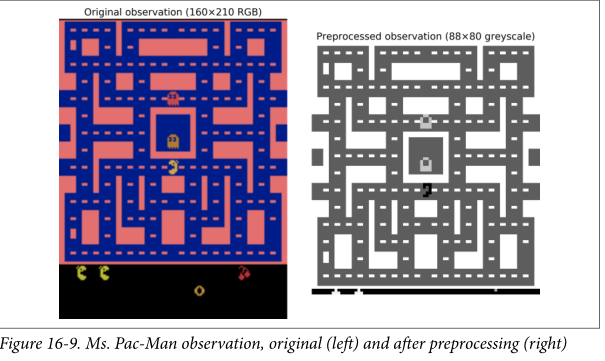

### 9.2  预处理

预处理图像是可选的，但大大加快了培训速度。

In [57]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

注意：preprocess_observation（）函数与书中的函数略有不同：它不是将像素表示为从-1.0到1.0的64位浮点数，而是将它们表示为有符号字节（**从-128到127**）。
好处是重放内存将少占用大约8倍的RAM（大约6.5 GB而不是52 GB）。 精度降低对训练没有明显影响。

<IPython.core.display.Javascript object>


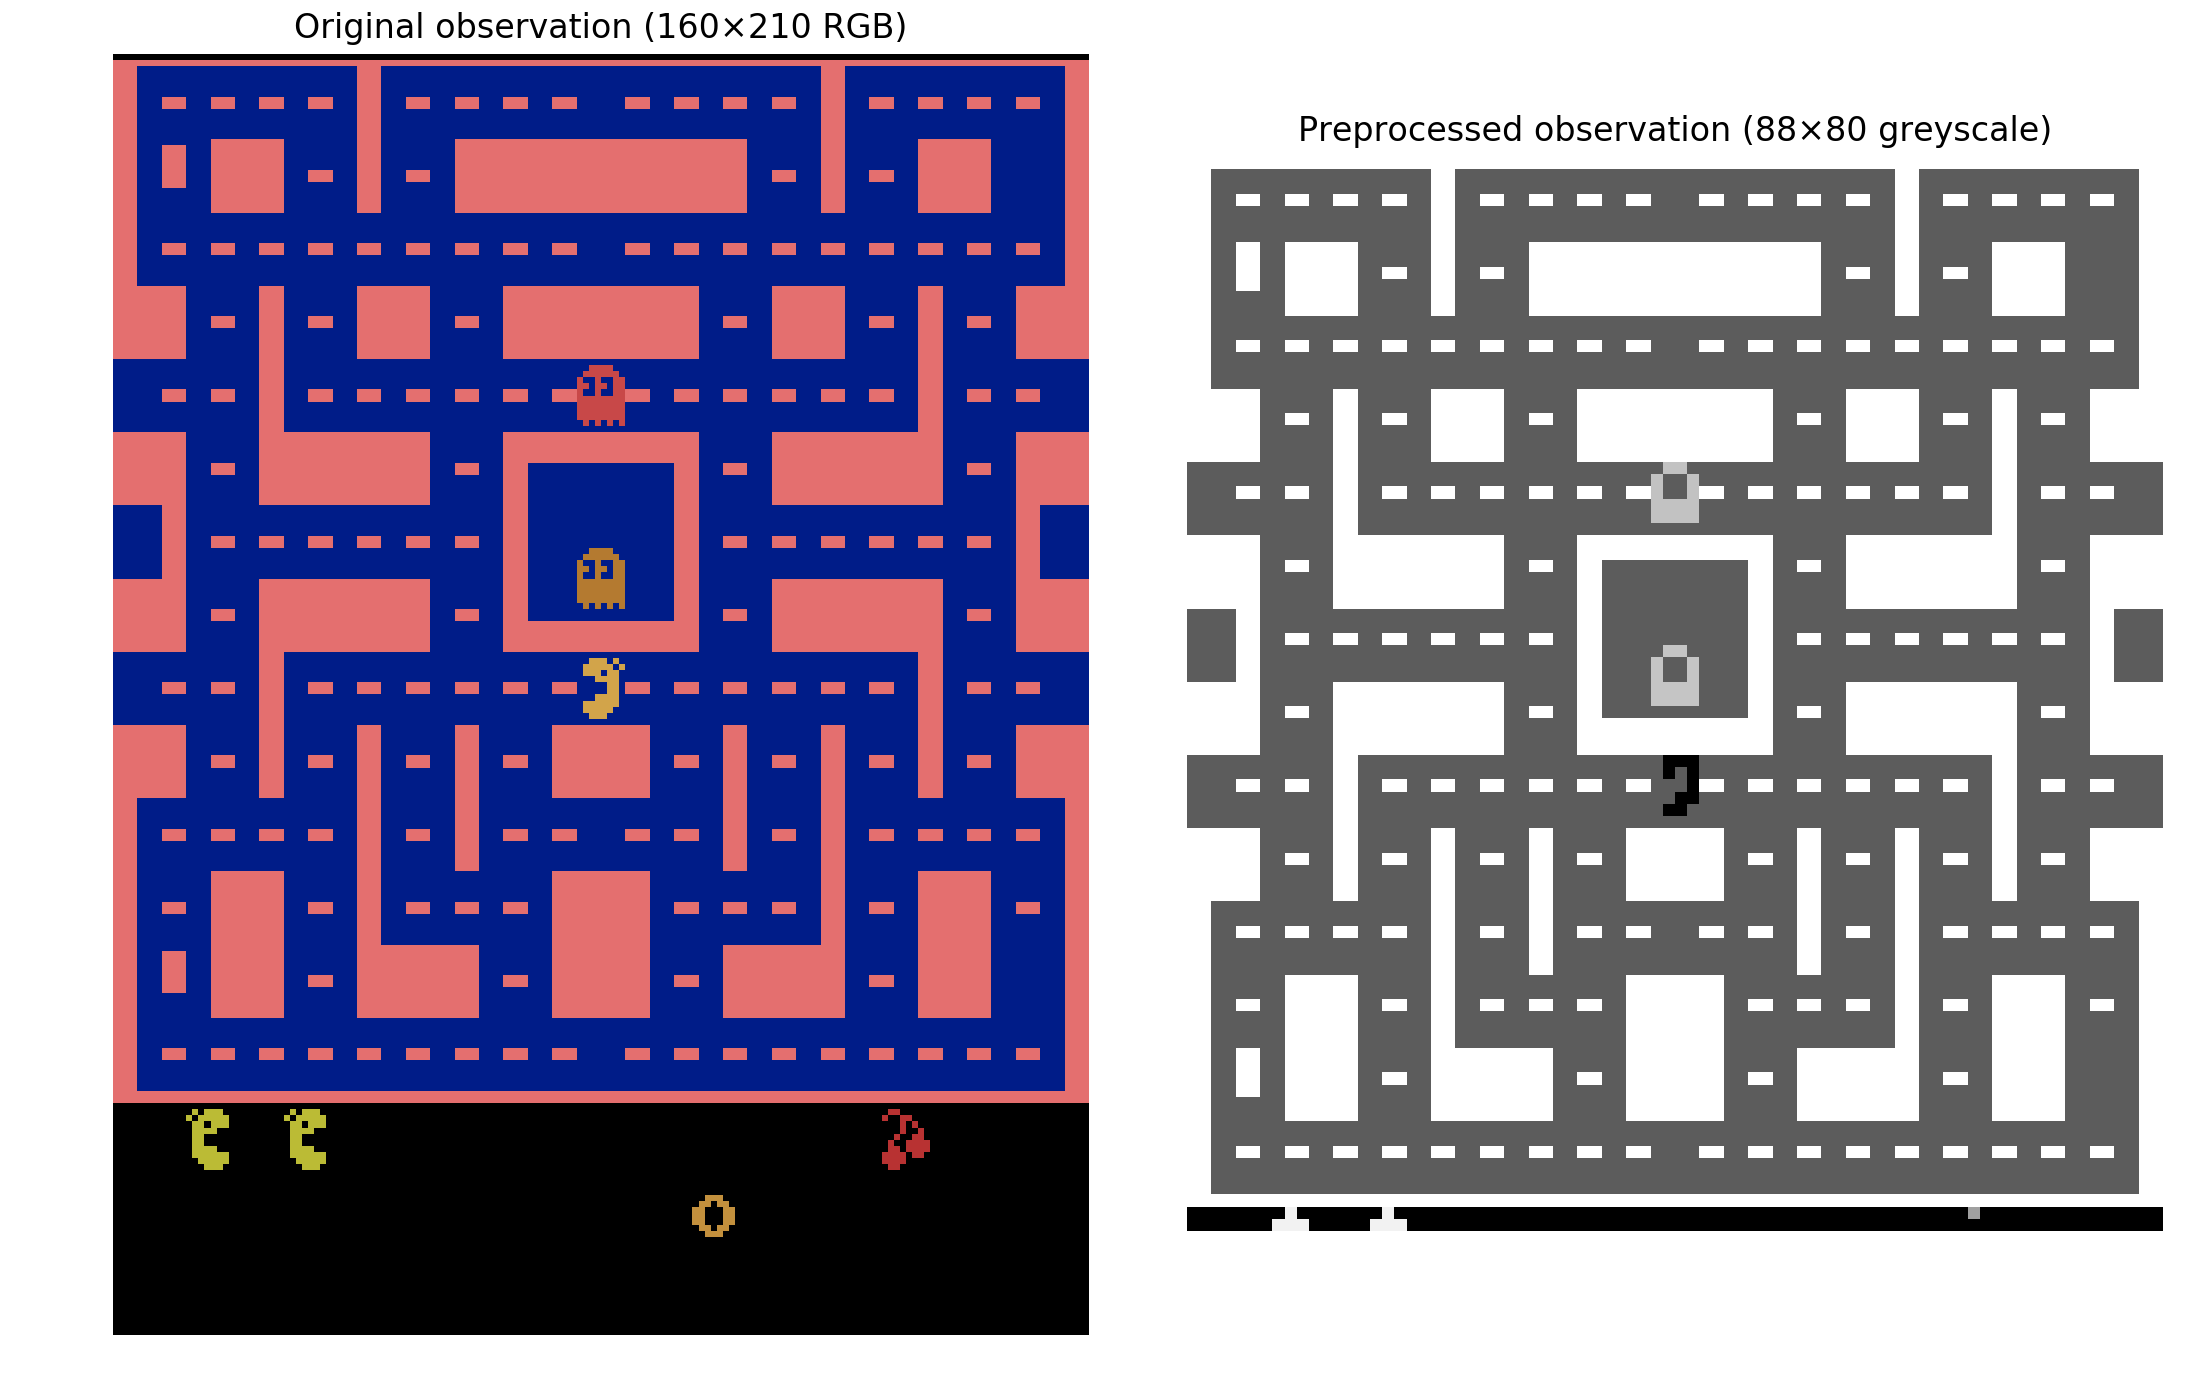

Saving figure preprocessing_plot


In [58]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

### 9.3 Build DQN

接下来，让我们创建DQN。 它**可以只使用状态 - 动作对$(s，a)$作为输入，并输出相应Q值Q(s，a)的估计值**，但由于动作是离散的，因此使用神经网络更方便 **仅采用状态 s 作为输入，并且每个动作输出一个Q值估计**。
DQN将由三个卷积层组成，接着是两个完全连接的层，包括输出层（见图16-10）。

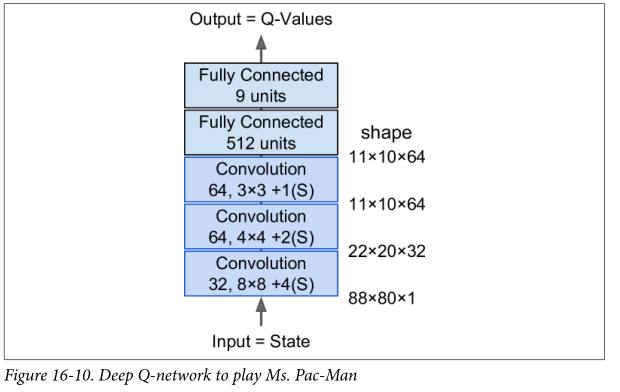

我们会看到，我们将使用的训练算法**需要两个具有相同架构（但参数不同）的DQN**：

* 一个将用于在训练期间驾驶Pac-Man女士（演员），
* 另一个将观看演员并从其试验和错误（评论家）中学习。
* 我们会**定期将评论家复制给演员**。

因为我们需要两个相同的DQN，我们将创建一个**q_network（）函数**来构建它们：

注意： 我们现在使用**tf.layers.conv2d（）**，（这一章编写时，当时不存在），而不是使用tf.contrib.layers.convolution2d（）或tf.contrib.layers.conv2d（）（如本书的第一个版本）。这是首选，因为contrib中的任何内容都可能更改或删除，恕不另行通知，而tf.layers是官方API的一部分。代码大致相同，只是参数名称略有改变：


*  `num_outputs` 参数已重命名为 `filters`,
*  `stride` 参数重命名为 `strides`,
*  `_fn` 后缀已从具有它的参数名称中删除（例如，activation_fn已重命名为 `activation`）,
*  `weights_initializer` 参数已重命名为 `kernel_initializer`,
*  weights variable 重命名为 `"kernel"` (而不是 `"weights"`), and the biases variable 从 `"biases"` 重命名为 `"bias"`,
*   默认 `activation` 现在是 `None` 而不是 `tf.nn.relu`.

In [59]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

* 该代码的第一部分定义了DQN架构的超参数。

* 然后q_network（）函数创建DQN，将环境的状态X_state作为输入，以及变量作用域的名称。请注意，我们将**只使用一个观察来表示环境的状态，因为几乎没有隐藏状态**（除了闪烁的对象和鬼魂的方向）。


* **trainable_vars_by_name**字典收集此DQN的所有**可训练变量 - the trainable variables**。它将在稍后当我们创建操作以将评论家DQN复制到演员DQN时起作用。

* 字典的键是变量的名称，剥去与作用域名称对应的前缀部分。 它看起来像这样：

现在让我们**创建输入占位符，两个DQN，以及将评论家DQN复制到演员DQN的操作**：

In [60]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

让我们暂停一下，回顾到目前位置我们做了哪些工作：

* 我们现在有两个DQN，它们都能够将环境状态（即，预处理的观察）作为输入并输出该状态中每个可能动作的估计Q值。

* 另外，我们有一个名为**copy_online_to_target**的操作，用于将评论家DQN的所有可训练变量复制到演员DQN。

* 我们使用TensorFlow的tf.group（）函数将所有赋值操作分组到一个方便的操作中。

演员DQN可以用来扮演Pac-Man女士（最初非常糟糕）。如前所述，我们希望它足够彻底地探索游戏，因此我们通常希望将其与$ε-贪婪$策略或其他探索策略相结合。


但是评论家DQN怎么样？ 它将如何学习玩游戏？简短的回答是，**它将尝试使其Q值预测与演员通过其游戏体验估计的Q值相匹配**。 具体来说，

* 我们将让演员玩一会儿，将其所有经验存储在**replay memory**中。

* 每个记忆将是5元组（状态，动作，下一状态，奖励，继续）- (state, action, next state, reward, continue)，其中“继续”这一项在游戏结束时将等于0.0，否则为1.0。

* 接下来，我们将定期从**replay memory**中采集一批**memories**，并从这些**memories**中估算Q值。

* 最后，我们将**训练评论家DQN使用常规监督学习技术预测这些Q值**。 每经过几次训练迭代，我们就会将评论家DQN复制到演员DQN。 就是这样！ 

公式16-7显示了**用于训练评论家DQN的成本函数**：

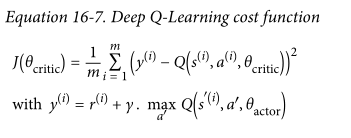

* $s(i)，a(i)，r(i)和s'(i)$ 分别是状态，动作，奖励和从replay memory中采样的第 $i$ 个memory 的下一个状态。
* $ m $ 是 memory batch的大小。
* $θ_{critic}$和$θ_{actor}$ 是评论家和演员的参数。
* $Q(s(i)，a(i)，θ_{critic})$ 是评论家DQN对第 $i$ 个memorized 状态 - 行动的Q值的预测。
* $Q(s'(i)，a',θ_{actor})$ 是演员DQN对下一个状态 $s'(i) $ 如果选择动作$ a'$ 可以预期的Q值的预测。
* $y(i)$是第 $i$ 个记忆的目标Q值。请注意，它等于演员实际观察到的奖励，加上演员预测如果优地发挥应有的未来奖励
(as far as it knows).
* $J(θ_{critic})$是用于训练评论家DQN的成本函数。如你所见，它只是由演员DQN估计的目标Q值 $y(i)$ 与评论家DQN对这些Q值的预测之间的均方误差。

replay memory是可选的，但强烈推荐。 没有它，你将使用可能非常相关的连续经验训练评论家DQN。 这会引入很多偏差并减慢训练算法的收敛速度。 通过使用replay memory，我们确保馈送到训练算法的memories（experiences）可以是非常不相关的。

In [61]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

让我们添加评论家DQN的训练操作。

* 首先，我们需要能够为**memory batch**中的每个状态操作计算其预测的Q值。由于DQN为每个可能的动作输出一个Q值，我们只需要保留与**该memory**中实际选择的动作相对应的Q值。为此，我们**将动作转换为单热矢量**（回想一下，除了第i个索引处的1之外，这是一个满0的向量），并将其乘以Q值：除了对应于memorized action的Q值之外，这将使所有Q值归零。

* 然后仅对第一轴求和以仅获得每个memory的期望Q值预测。
```python
X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs),
                        axis=1, keep_dims=True)
```


* 接下来让我们添加训练操作，假设**目标Q值将通过占位符提供**。

* 我们还创建了一个名为**global_step的非连续变量**。优化器的**minimize（）操作**将负责增加它。
* 另外，我们创建了常用的**init**操作和**Saver**

```python
y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
```

In [62]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

注意：在本书的第一个版本中，**损失函数只是目标Q值（y）和估计Q值（q_value）之间的平方误差**。但是，**由于经验非常嘈杂，最好只对小误差（低于1.0）使用二次损失，对较大误差使用线性损失（绝对误差的两倍）**，这就是上面的代码计算的结果。这样，大错误不会将模型参数推到尽可能多的位置。

请注意，我们还调整了一些超参数（**使用较小的学习率，并使用Nesterov Accelerated Gradients而不是Adam优化，因为根据本文，自适应梯度算法有时可能很糟糕**）。

我们还调整了下面的一些其他超参数（较大的replay memory，$εε-greedy$策略的较长衰减，较大的折扣率，online DQN 到 target DQN较小的拷贝频率等）。

上面是**构建阶段**。 在我们查看**执行阶段**之前，我们需要一些工具。 

* 首先，让我们从实现replay memory开始。我们使用ReplayMemory类而不是deque，因为随机访问速度要快得多（感谢@NileshPS贡献它）。
* 我们还将编写一个小函数来从replay memory中随机抽取一批经验：

此外，**we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories**.

In [63]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [64]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [65]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

* 接下来，我们需要演员来探索游戏。我们将使用$ε-greedy$ 策略，并在50,000个训练步骤中逐渐将$ε$**从1.0减少到0.1**：

In [66]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

我们现在拥有开始训练所需的一切。

**执行阶段**不包含任何太复杂的东西，但它有点长，所以深呼吸。准备好了吗？ 我们走吧！ 

* 首先，让我们初始化一些变量：

In [67]:
n_steps = 4000000  # 训练步骤总数
training_start = 10000  # 在10,000次游戏迭代后开始训练
training_interval = 4  # 每4次游戏迭代运行一次训练步骤
save_steps = 1000  # 每1,000个训练步骤保存模型
copy_steps = 10000  # 每40个训练步骤复制在线DQN以达到目标DQN
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # 游戏迭代
checkpoint_path = "./my_dqn.ckpt"
done = True # 重置环境

跟踪进度的一些变量：

In [68]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

* 接下来，让我们打开会话并运行主训练循环：

In [69]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # 游戏结束，重新开始
            obs = env.reset()
            for skip in range(skip_start): # 跳过每场比赛的开始
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # 在线DQN评估要做什么
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # 在线DQN在玩游戏
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        #   采样memories并使用目标DQN产生目标Q值
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # 训练在线DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # 定期将在线DQN复制到目标DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly-定期保存模型
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


[2017-09-25 13:55:15,610] Restoring parameters from ./my_dqn.ckpt


Iteration 1270171	Training step 315001/4000000 (7.9)%	Loss 2.651937	Mean Max-Q 30.964941   

你可以随时中断上面的单元格，使用下面的单元格测试你的智能体。 然后，你可以再次运行上面的单元格，它将加载最后保存的参数并恢复训练。

In [70]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


[2017-09-25 13:53:39,307] Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


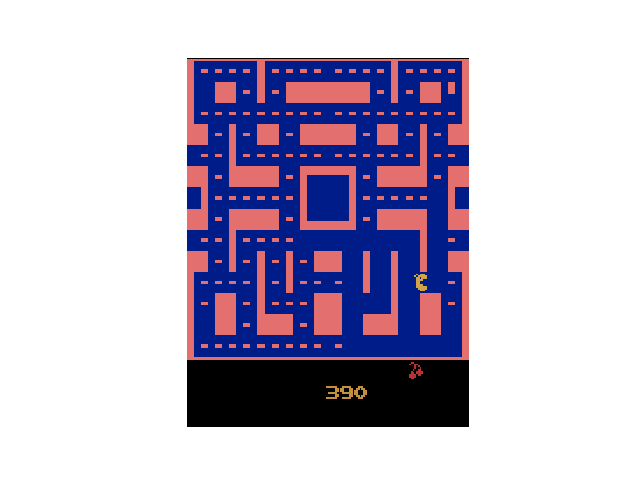

In [71]:
plot_animation(frames)

如果存在检查点文件，
* 我们首先恢复模型，否则我们只是正常初始化变量。

* 然后主循环开始，其中迭代计算自程序启动以来我们经历的游戏步骤的总数，并且步骤计算（step counts）自训练开始以来的训练步骤的总数（如果恢复检查点，则还恢复全局步骤） ）。

* 然后代码重置游戏（并跳过第一个无聊的游戏步骤，没有任何反应）。

* 接下来，演员评估要做什么，并玩游戏，并将其experience 存在replay memory中。

* 然后，以**固定间隔（在预热期后），对评论家进行训练**。它对a batch of memories 进行采样，并要求演员估计下一个状态的所有动作的Q值，并应用公式16-7计算目标Q值 **Y_val**。这里唯一棘手的部分是我们必须将下一个状态的Q值乘以连续向量（continues vector），将对应于游戏结束的memories 的Q值归零。

* 接下来，我们进行一项训练操作，以提高评论家预测Q值的能力。
* 最后，我们定期将评论家复制给演员，然后保存模型。

不幸的是，训练非常缓慢：

如果你使用笔记本电脑进行训练，那么Pac-Man女士可能需要几天才能获得任何好处，如果你查看学习曲线，测量每集的平均奖励，你会发现它非常嘈杂。在某些时候，很长一段时间内可能没有明显的进展，直到突然间 agent 学会在合理的时间内存活。

如前所述，一种解决方案是尽可能多地将先验知识注入到模型中（例如，通过预处理，奖励等），并且你还可以尝试通过首先训练模型以模仿基本策略来引导模型。**在任何情况下，RL仍然需要相当多的耐心和调整，但最终的结果是非常令人兴奋的**。

# Extra material

## Preprocessing for Breakout

这是一个预处理函数，你可以使用它来**为Breakout-v0 Atari游戏训练DQN**：

In [73]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [74]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

[2017-09-25 13:54:27,989] Making new env: Breakout-v0


<IPython.core.display.Javascript object>


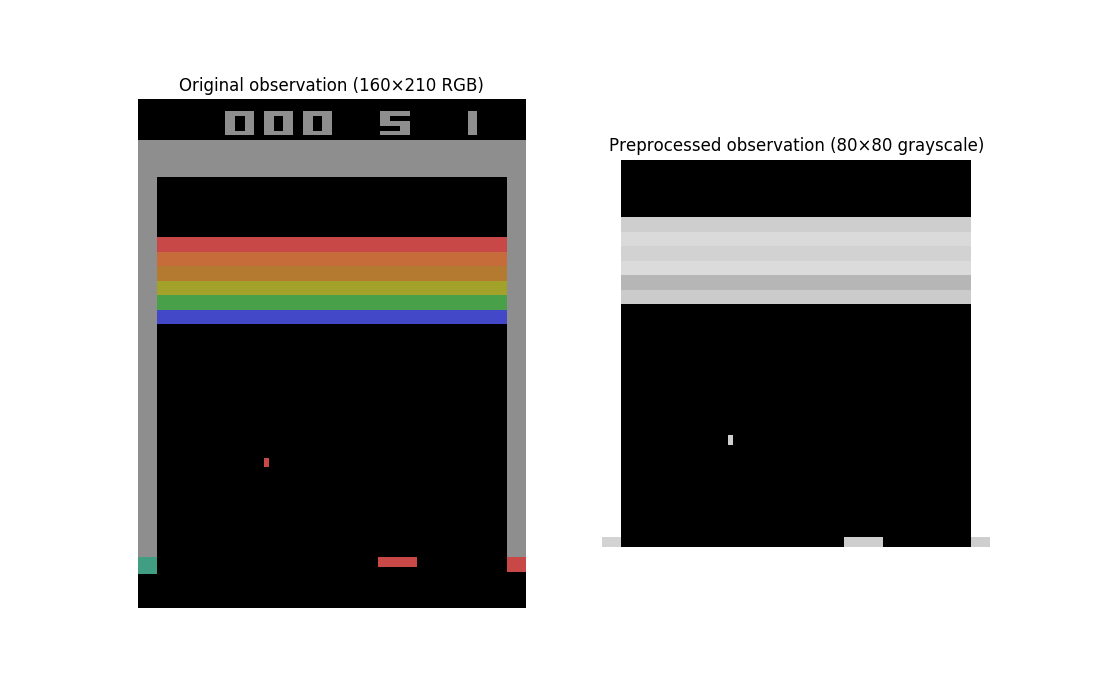

In [75]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

正如你所看到的，单个图像并没有给你球的方向和速度，这是玩这个游戏的关键信息。因此，最好实际组合几个连续的观察来创建环境的状态表示。

* 一种方法是创建一个多通道图像，每个最近观察一个通道。
* 另一种方法是使用np.max（）将所有最近的观察结果合并为单通道图像。在这种情况下，我们需要调暗旧图像，以便DQN可以区分过去和现在。

In [76]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

<IPython.core.display.Javascript object>


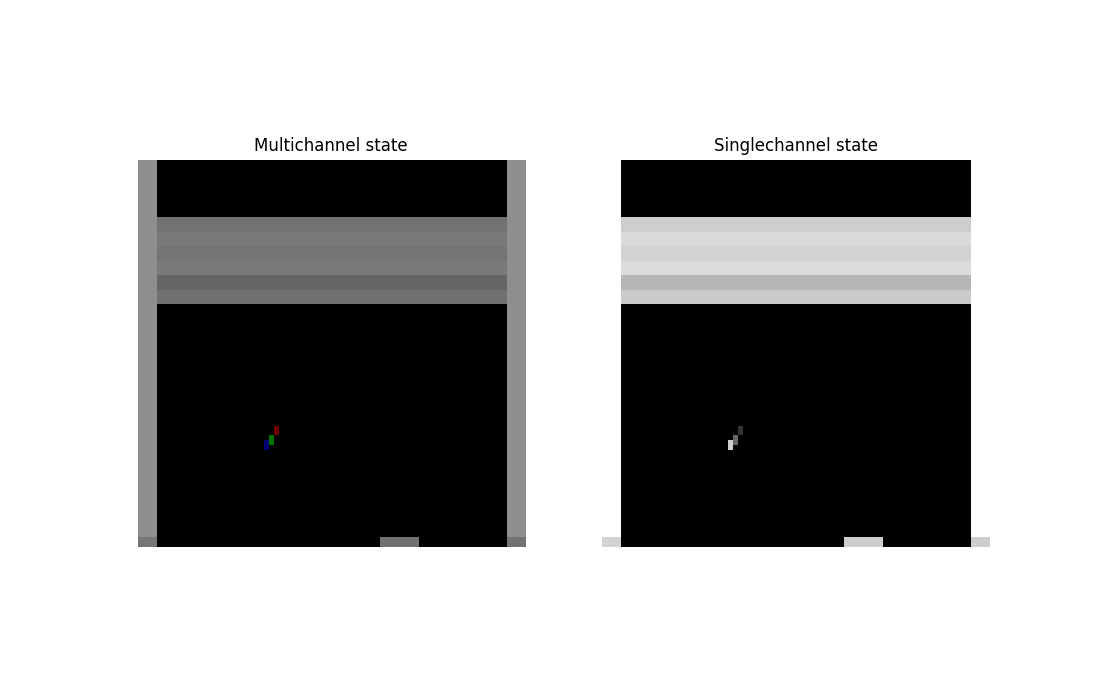

In [77]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

# Exercise solutions

## 1. to 7.

1-7 请移步[我的简书](https://www.jianshu.com/p/d13aaf69978d)

## 8. BipedalWalker-v2

第8题同样由于我的电脑问题目前无法实现，好心痛，大家可以看出硬件对我们有多么重要了。不是因为我的笔记本不够好，而是因为我买的是游戏本，这个本子对ubuntu系统支持的不太好，装过几次，特别容易崩，如果只是换系统，还是很快的，可是再搭建深度学习，强化学习的环境就不是那么开心了，三天两头重装系统实在麻烦；实验室也没有给配备别的电脑，目就做到这一步了。

Exercise: _使用 策略梯度 来解决 OpenAI gym's "BipedalWalker-v2"._

In [49]:
import gym

In [ ]:
env = gym.make("BipedalWalker-v2")

Note: if you run into [this issue](https://github.com/openai/gym/issues/100) ("`module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'`") when making the `BipedalWalker-v2` environment, then try this workaround:

```
$ pip uninstall Box2D-kengz
$ pip install git+https://github.com/pybox2d/pybox2d
```

In [80]:
obs = env.reset()

In [81]:
img = env.render(mode="rgb_array")

In [82]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [83]:
obs

array([ 2.74730590e-03, -2.55714543e-05,  1.98919237e-03, -1.59998274e-02,
        9.17998850e-02, -2.62505747e-03,  8.60360265e-01,  3.34233418e-03,
        1.00000000e+00,  3.22045349e-02, -2.62487587e-03,  8.53911370e-01,
        1.85646505e-03,  1.00000000e+00,  4.40814108e-01,  4.45820212e-01,
        4.61422890e-01,  4.89550292e-01,  5.34102917e-01,  6.02461159e-01,
        7.09149063e-01,  8.85932028e-01,  1.00000000e+00,  1.00000000e+00])

你可以在[documentation](https://github.com/openai/gym/wiki/BipedalWalker-v2)找到这24个数字中每个数字的含义.

In [84]:
env.action_space

Box(4,)

In [85]:
env.action_space.low

array([-1., -1., -1., -1.], dtype=float32)

In [86]:
env.action_space.high

array([1., 1., 1., 1.], dtype=float32)

这是一个4D连续动作空间，控制每条腿的髋部扭矩和膝盖扭矩（从-1到1）。为了处理连续的行动空间，一种方法是将其离散化。
 例如，让我们将可能的扭矩值限制为这3个值：-1.0,0.0和1.0。 这意味着我们留下$3^4=81$ 个可能的行动。

In [87]:
from itertools import product

In [88]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

(81, 4)

In [89]:
tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)

# 4. Training
learning_rate = 0.01

y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

让我们尝试运行这个策略网络，虽然它尚未经过训练。

In [90]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
    env.close()
    return frames

<IPython.core.display.Javascript object>


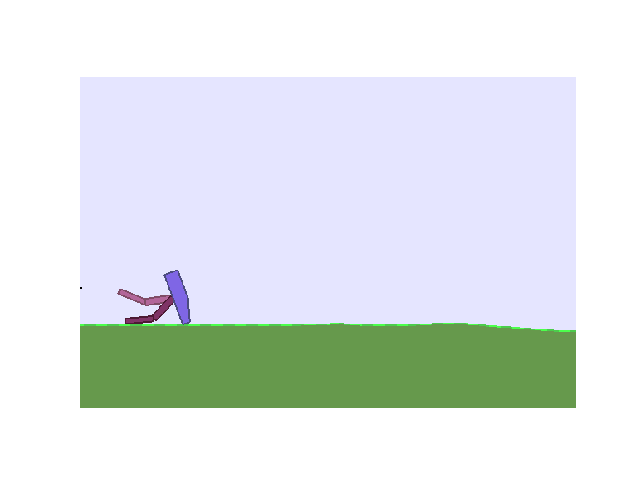

In [91]:
frames = run_bipedal_walker()
video = plot_animation(frames)
plt.show()

看来它是真的不会走. 那就让我们训练吧！

In [92]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

Iteration: 1000/1000

INFO:tensorflow:Restoring parameters from ./my_bipedal_walker_pg.ckpt


<IPython.core.display.Javascript object>


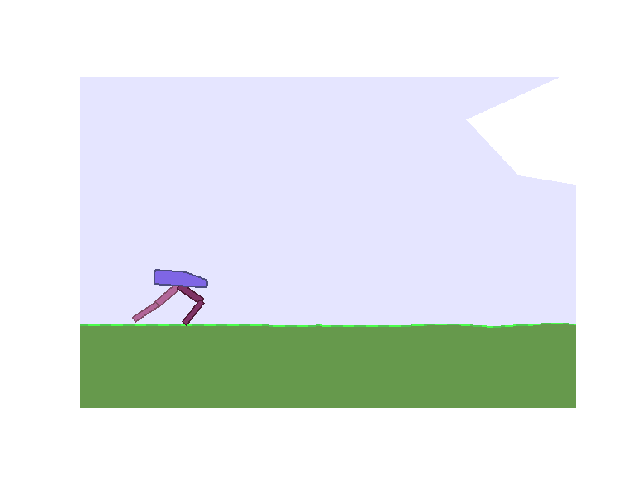

In [93]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
plt.show()

不是最好的步行者，但至少它会保持向上并使（缓慢）向右进展。 针对此问题的更好解决方案是使用actor-critic算法，因为它不需要对动作空间进行离散化，并且它会收敛得更快。 查看Yash Patel的这篇精彩[博文](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69) ，了解更多详情。

## 9.

**Coming soon**